In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.QED import qed


# ---- INPUTS ----
# CSV used for ranking & grid labels (produced by your step that summarizes best poses)
TOP_POSE_CSV   = Path("output_step4-v6/top_pose_hits.csv")

# SDF that contains ALL POSES for all CIDs (each pose is a separate record)
ALL_POSES_SDF  = Path("output_step4-v6/top_pose_hits.sdf")

# Where per-CID SDFs will be written
PER_CID_DIR    = Path("output_step4-v6/per_cid_sdfs")
PER_CID_DIR.mkdir(parents=True, exist_ok=True)

# Grid image outputs
GRID_SVG       = TOP_POSE_CSV.with_name("top_hits_grid.svg")
GRID_PNG       = TOP_POSE_CSV.with_name("top_hits_grid.png")

# Selection
TOP_N          = 10                 # extract all poses for these top-N ligands
TARGET_EXTRA_CID = "COLIG_2A6"      # always include this one

# Score column name in CSV (adjust if yours differs)
CSV_SCORE_COL  = "docking_score"    # lower is better for docking
CSV_SMILES_COL = "SMILES"           # for grid drawing
CSV_CID_COL    = "CID"              # ligand identifier

# Legend formatting & grid visuals
N_COLS         = 5
CELL_W, CELL_H = 380, 360   # per-molecule drawing size (px)
LEGEND_FONT    = 22         # larger, readable legends

## **Step 2 : Read top_pose_hits.csv created in the previous step for processing**

In [2]:
# Cell 2 — load CSV and pick the top-N CIDs
top_df = pd.read_csv(TOP_POSE_CSV)

# Ensure required columns exist
for col in [CSV_CID_COL, CSV_SCORE_COL]:
    if col not in top_df.columns:
        raise ValueError(f"CSV missing required column: {col}")

# sort by score ascending (lower is better)
top_df_sorted = top_df.sort_values(by=[CSV_SCORE_COL, CSV_CID_COL], ascending=[True, True]).reset_index(drop=True)

top_cids = (
    top_df_sorted
    .dropna(subset=[CSV_CID_COL])
    .groupby(CSV_CID_COL, as_index=False)
    .first()
    .sort_values(CSV_SCORE_COL, ascending=True)[CSV_CID_COL]
    .head(TOP_N)
    .tolist()
)

# always include the extra CID if present in data
if TARGET_EXTRA_CID not in top_cids:
    top_cids.append(TARGET_EXTRA_CID)

print("Top CIDs (including forced):", top_cids)

Top CIDs (including forced): ['Z1041114218', 'Z57110395', 'Z357964720', 'Z1677967961', 'Z94803042', 'Z24682342', 'Z56974472', 'Z107740192', 'Z1576583090', 'Z56854611', 'COLIG_2A6']


In [3]:
# --- minimal utilities required by Cell 3 ---

from rdkit import Chem
import numpy as np
import pandas as pd
import re

def read_sdf_with_props(sdf_path, sanitize=True, removeHs=False):
    suppl = Chem.SDMolSupplier(str(sdf_path), sanitize=sanitize, removeHs=removeHs)
    return [m for m in suppl if m is not None]

def get_prop(m, name, default=None, cast=None):
    if m.HasProp(name):
        v = m.GetProp(name)
        if cast is not None:
            try:
                return cast(v)
            except Exception:
                return default
        return v
    return default

def guess_cid(mol) -> str:
    """Prefer 'CID'; else use '_Name' and strip trailing '_pose\\d+'"""
    if mol.HasProp("CID"):
        return mol.GetProp("CID").strip()
    if mol.HasProp("_Name"):
        nm = mol.GetProp("_Name").strip()
        return re.sub(r"_pose\d+$", "", nm, flags=re.IGNORECASE)
    return ""

### **Step 3 : Indexing and Sorting AutoDock Poses**

In this step, all ligand poses generated by **AutoDock Vina** are indexed and organized for downstream analysis.

Each molecule and its associated docking poses are read from the aggregated `all_poses.sdf` file,  
and key metadata are extracted, including:
- **CID** — the compound identifier  
- **score** — AutoDock’s predicted binding energy (kcal/mol)  
- **pose_index** — the pose rank as output by Vina  

All poses are stored in a DataFrame and sorted by:
1. **Compound ID (CID)**  
2. **Docking score** (ascending — better scores first)  
3. **Pose index**  

This ensures that for every compound, the top-ranked (lowest energy) poses appear first,  
facilitating rapid identification of the best conformations for further evaluation.

The output table provides a structured overview of all ligand poses, enabling subsequent  
filtering, visualization, and hit selection workflows.


In [4]:
# Cell 3 — index poses from the all-poses SDF
pose_mols = read_sdf_with_props(ALL_POSES_SDF, sanitize=True, removeHs=False)

rows = []
for m in pose_mols:
    cid = guess_cid(m)
    score = get_prop(m, "docking_score", default=np.inf, cast=float)
    pose_idx = get_prop(m, "pose_index", default=-1, cast=int)
    rows.append({"CID": cid, "score": score, "pose_index": pose_idx, "mol": m})

df_poses = pd.DataFrame(rows)
df_poses_sorted = (
    df_poses
    .dropna(subset=["CID"])
    .sort_values(by=["CID", "score", "pose_index"], ascending=[True, True, True])
    .reset_index(drop=True)
)

print(f"Loaded {len(df_poses_sorted)} pose entries from {ALL_POSES_SDF.name}")
df_poses_sorted.head(3)

Loaded 88 pose entries from top_pose_hits.sdf


,CID,score,pose_index,mol
0,123658957,-9.574,1,<rdkit.Chem.rdchem.Mol object at 0x77e555529cb0>
1,123953120,-9.798,1,<rdkit.Chem.rdchem.Mol object at 0x77e555529d20>
2,46927371,-9.453,3,<rdkit.Chem.rdchem.Mol object at 0x77e555529d90>


In [5]:
mols, legends = [], []

def to_legend(row):
    # Short 2-line legend: CID + score | viable poses + RMSD std to best
    # Feel free to tweak formatting
    return (
        f"{row['CID']}\n"
        f"Score: {row['docking_score']:.2f} | n={int(row['num_viable_poses'])}\n"
        f"sig(RMSD→best): {row['rmsd_to_best_std']:.2f} Å"
    )

for _, r in top_df.iterrows():
    smi = (r.get("SMILES") or "").strip()
    if not smi:
        continue
    m = Chem.MolFromSmiles(smi)
    if m is None:
        continue
    # Add 2D coords for nice depictions
    Chem.rdDepictor.Compute2DCoords(m)
    mols.append(m)
    legends.append(to_legend(r))

len(mols)

88

### Visualize the top scoring molecules which also have "Converged" poses 
- The pose convergence was selected based on pairwise RMSD of the poses from the top scoring pose. per molecule
- Only those molecule which had better than >= 5 converged poses were considered hits
- Those hits(top poses) were written in the top_poses_hits.csv

/home/pchatterjee/anaconda3/envs/autodock-diffdock/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


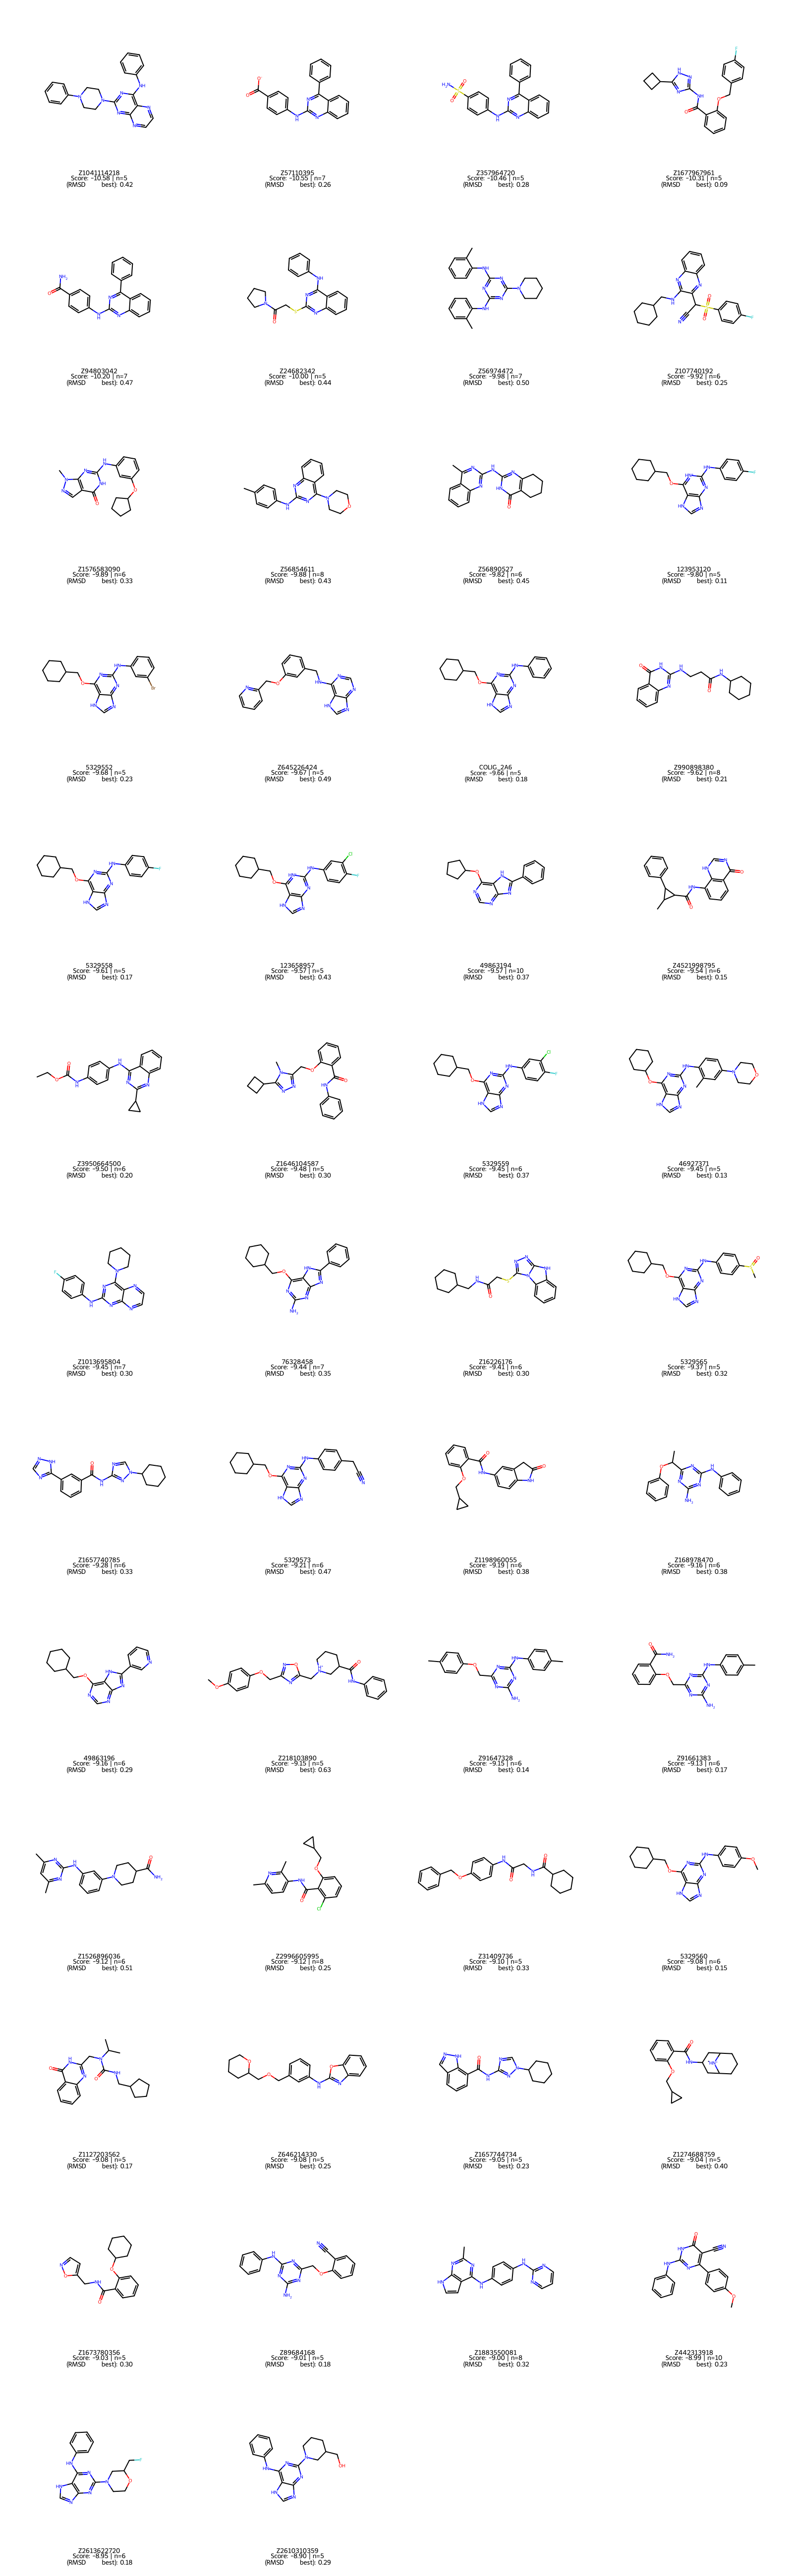

In [6]:
# Choose size per cell
cell_w, cell_h = 300, 240  # width x height in pixels per molecule

# Compute rows from TOP_N and N_COLS
n_cols = N_COLS
n_rows = (len(mols) + n_cols - 1) // n_cols

# Draw grid image (PIL)
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=4,
    subImgSize=(400, 400),
    legends=legends,
    useSVG=False
)

#display(img)  # Jupyter inline

# Save PNG
#img.save(GRID_PNG)
img

## **Pose Analysis**

- Of the top 10 ranked compounds two Z56974472 and Z56854611 have very good pose alignment with the X-ray pose of the co-crystal ligand
  - **Xray : Yellow | Z56974472 : Magenta | Z56854611 : Blue**
  - The pose shows the Hinge binding interaction of the two molecule's "best poses"
          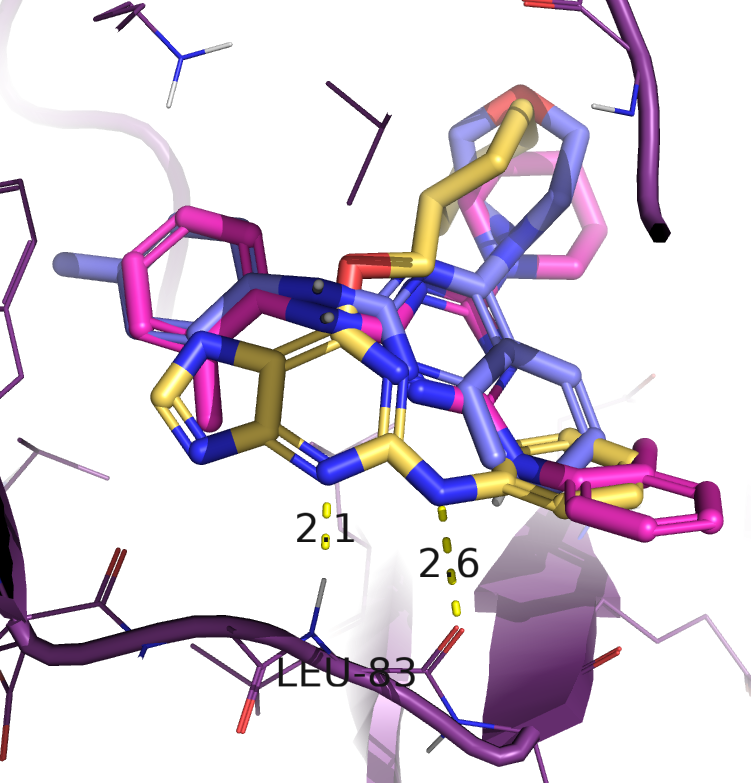
          
- Also, note that the core substructures are very unique, but similar to the **purine based core** :
  - Z56974472 has a **triazine core**
  - Z56854611 has a **quinazoline core**
- The R group extending from the cores for the X-ray ligand 2A6 and Z56974472 and Z56854611 are also very similar :
  -  Z56974472 has **piperidyl group** | Z56854611  has a **morpholino group** | while 2A6 has a **cyclohexylmethoxy group**
  -  This R vector is also very well aligned with 2A6 

##### The chosen best 3 poses of the co-crystal ligand did not overaly with the 3D X-ray pose of the co-crytsal ligand
- **Reference X-ray pose in Yellow | 2A6 docked best pose in light pink**
     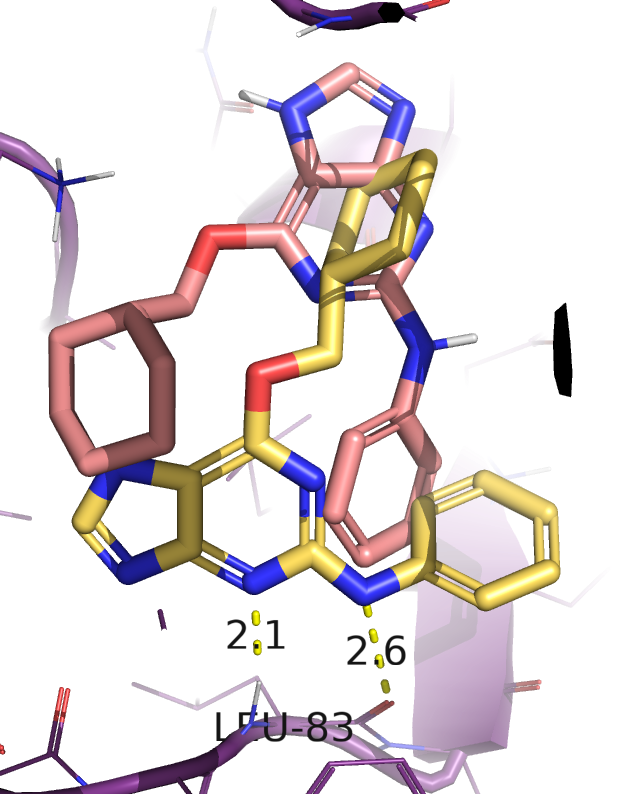
   
- For the **docked co-crystal ligand**: **1/10 poses obtained with autodock-vina overlays well** in the pocket, with the  **co-crystal X-ray**:

     | **Xray in Yellow** | **1/10 Pose in Grey** |

    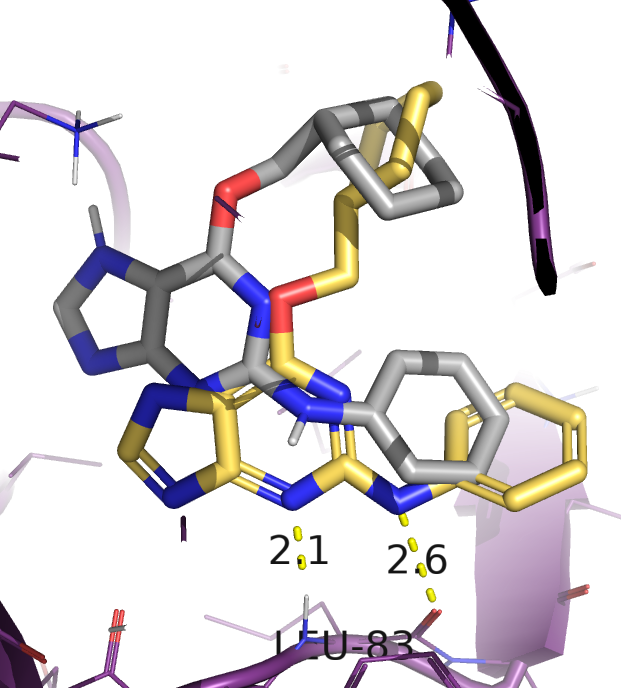

##### The selection algorithm was focused on selecting molecules with a pairwise RMSD convergence within 2 A
- This allowed compounds such as Z56974472 and Z56854611 to be picked as top hits which are also structurally similar to the co crystal ligands 2A6

## Step 2: Molecular Property Calculation and Ranking

This script augments docking results with key drug-likeness and ADME-relevant descriptors using **RDKit**:

- **LE (Ligand Efficiency)** – Normalizes binding affinity by molecular size (`|Docking Score| / Heavy Atom Count`).
- **nRotB (Number of Rotatable Bonds)** – Estimates molecular flexibility.
- **logS (Estimated Aqueous Solubility)** – Predicted via the **ESOL** model based on molecular weight, logP, TPSA, and aromaticity.
- **QED (Quantitative Estimate of Drug-likeness)** – Composite drug-likeness metric from RDKit.

The script reads the docking output file (`top_pose_hits.csv`), computes these properties for each molecule,  
and exports the results to **`top_poses_with_props.csv`**.


In [8]:
def calc_esol_logS(mol):
    """Estimate aqueous solubility using the RDKit ESOL model."""
    MW = Descriptors.MolWt(mol)
    logP = MolLogP(mol)
    TPSA = rdMolDescriptors.CalcTPSA(mol)
    rotB = Lipinski.NumRotatableBonds(mol)
    AromRings = rdMolDescriptors.CalcNumAromaticRings(mol)
    AromProportion = AromRings / rdMolDescriptors.CalcNumRings(mol) if rdMolDescriptors.CalcNumRings(mol) else 0
    logS = 0.16 - 0.63*logP - 0.0062*MW + 0.066*rotB - 0.74*AromProportion
    return logS

def calc_props(smiles, docking_score):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series([None]*4, index=['LE','nRotB','logS','QED'])
    n_heavy = mol.GetNumHeavyAtoms()
    LE = abs(docking_score) / n_heavy if n_heavy > 0 else None
    nRotB = Lipinski.NumRotatableBonds(mol)
    logS = calc_esol_logS(mol)
    QED_score = qed(mol)
    return pd.Series([LE, nRotB, logS, QED_score], index=['LE','nRotB','logS','QED'])

# ---- Main ----
df = pd.read_csv("output_step4-v6/top_pose_hits.csv")  # ensure a 'SMILES' column exists
results = df.apply(lambda row: calc_props(row['SMILES'], row['docking_score']), axis=1)
df = pd.concat([df, results], axis=1)
df.to_csv("top_poses_with_props.csv", index=False)

print("Added LE, nRotB, logS, QED to top_poses_with_props.csv")


Added LE, nRotB, logS, QED to top_poses_with_props.csv


In [9]:
df.round(2)

,CID,pose_index,docking_score,num_viable_poses,rmsd_pairwise_std,rmsd_to_best_std,MWT,TPSA,logP,HBD,HBA,SMILES,LE,nRotB,logS,QED
0,Z1041114218,1,-10.58,5,0.36,0.42,383.46,70.07,3.49,1,7,[H]c1nc2nc(N3C([H])([H])C([H])([H])N(c4c([H])c...,0.36,4.0,-4.74,0.58
1,Z57110395,1,-10.55,7,0.44,0.26,340.36,77.94,3.40,1,5,[H]c1c([H])c([H])c(-c2nc(N([H])c3c([H])c([H])c...,0.41,4.0,-4.57,0.62
2,Z357964720,1,-10.46,5,0.24,0.28,376.44,97.97,3.69,2,5,[H]c1c([H])c([H])c(-c2nc(N([H])c3c([H])c([H])c...,0.39,4.0,-4.97,0.57
3,Z1677967961,1,-10.31,5,0.17,0.09,366.40,79.90,4.04,2,4,[H]c1c([H])c([H])c(C(=O)N([H])c2nc(C3([H])C([H...,0.38,6.0,-4.82,0.69
4,Z94803042,1,-10.20,7,0.39,0.47,340.39,80.90,4.14,2,4,[H]c1c([H])c([H])c(-c2nc(N([H])c3c([H])c([H])c...,0.39,4.0,-5.03,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Z3000762692,2,-7.90,6,0.29,0.12,323.40,64.11,3.15,1,4,[H]c1nc(C([H])(N([H])C(=O)c2c([H])c([H])c([H])...,0.33,7.0,-3.74,0.85
84,Z48852930,1,-7.89,6,0.43,0.68,317.41,63.25,3.29,2,5,[H]c1c([H])c([H])c(N([H])C(=O)c2sc(N([H])C([H]...,0.36,5.0,-4.05,0.89
85,Z56840013,1,-7.75,5,0.42,0.22,309.38,97.44,2.72,3,6,[H]c1c([H])c([H])c(N([H])c2c(-c3nnc4n3C([H])([...,0.34,3.0,-3.83,0.69
86,Z16226228,1,-7.30,5,0.35,0.49,343.46,75.08,3.14,2,5,[H]c1c([H])c([H])c2c(c1[H])n([H])c1nnc(SC([H])...,0.30,4.0,-4.24,0.56


## Step 3:  Ranking molecules with Poses + Score + ADME properties

This script re-ranks docked ligands based on **pose reliability**, **ADME properties**, and **docking performance**, rather than relying solely on docking scores.  
In practical virtual screening, docking scores alone are not an absolute measure of binding quality.  
Hence, we integrate multiple criteria reflecting both **pose convergence** and **drug-likeness**.

#### **Assumptions**
Although our data indicated variability in the poses, for this exercise we assume:
- Each ligand has **highly converged poses** (all 10 poses within 1 Å RMSD).
- The conformations overlay as **ideal hinge binders**.

#### **Ranking Criteria and Priorities**
| Rank | Criterion | Type | Description |
|------|------------|------|-------------|
| 1 | `rmsd_to_best_std` | Cost | Pose convergence (lower = better) |
| 2 | `num_viable_poses` | Benefit | Pose stability (higher = better) |
| 3 | `LE` | Benefit | Ligand efficiency (higher = better) |
| 4 | `docking_score` | Cost | Docking energy (lower = better) |
| 5 | `QED` | Benefit | Drug-likeness (higher = better) |
| 6 | `nRotB` | Cost | Flexibility (lower = better) |

#### **Methodology**
1. **Normalize** each metric to a 0–1 scale.  
2. **Compute Rank Order Centroid (ROC) weights** to reflect relative importance of criteria.  
3. **Aggregate** weighted scores into a composite `ROC_score`.  
4. **Rank** ligands in descending order of `ROC_score`.

#### **Output**
- A ranked list of ligands with normalized criteria and composite ROC scores.  
- Results saved as **`ligand_ranked_ROC.csv`**.

This ensures ligand prioritization balances both docking accuracy and physicochemical viability, simulating a realistic early-stage hit triage process.


## **Section 3 — Rank Order Centroid (ROC) -weighted ranking**

##### **About Rank Order Centroid (ROC) Weighting Method** :
The **Rank Order Centroid (ROC)** method converts qualitative rankings of metric importance into quantitative weights that sum to 1.  
If there are *n* criteria ranked by importance, the weight for criterion *j* is:

$$
w_j = \frac{1}{n} \sum_{k=j}^{n} \frac{1}{k}
$$

ROC was used here to objectively combine multiple ligand evaluation metrics  : (**docking score**, **num_viable_poses**,**rmsd_pairwise_std**,**LE**, **QED**, **nRotB**) into a single composite score.  
It avoids arbitrary weighting and ensures more important criteria contribute proportionally more to the overall rank.

**Reference:**  
Barron, F. H., & Barrett, B. E. (1996). *Decision quality using ranked attribute weights.*  
**Management Science, 42(11), 1515–1523.** [https://doi.org/10.1287/mnsc.42.11.1515](https://doi.org/10.1287/mnsc.42.11.1515)



#### **Apply a Rank Order Centroid (ROC) weighting method to integrate multiple metrics into a composite score**.  
Steps:
1. Normalize all metrics to 0–1 scale (benefit vs. cost direction).
2. Assign ROC weights by decreasing metric importance.
3. Compute the composite `ROC_score` for each ligand.
Higher `ROC_score` = better compromise between scores + convergence and ADME quality.


In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# === Load your CSV ===
df = pd.read_csv("top_poses_with_props.csv")

# --- Scoring metrics and directions ---
# Custom rank order (1 = most important)
criteria = [
    'rmsd_to_best_std',      # Rank 1
    'num_viable_poses',      # Rank 2
    'LE',                    # Rank 3
    'docking_score',         # Rank 4
    'QED',                   # Rank 5
    'nRotB'                  # Rank 6
]

# Benefit vs cost direction
benefit = ['num_viable_poses', 'LE', 'QED']  # higher = better
cost = ['rmsd_to_best_std', 'docking_score', 'nRotB']  # lower = better

# --- Compute Rank Order Centroid Weights ---
n = len(criteria)
weights = []
for j in range(1, n + 1):
    wj = sum(1 / k for k in range(j, n + 1)) / n
    weights.append(wj)
weights = [w / sum(weights) for w in weights]  # normalize sum=1

roc_weights = dict(zip(criteria, weights))
print("ROC Weights:")
for k, v in roc_weights.items():
    print(f"{k:20s} {v:.3f}")

# --- Normalize metrics to 0-1 scale ---
scaler = MinMaxScaler()
for col in benefit:
    df[col + '_norm'] = scaler.fit_transform(df[[col]])
for col in cost:
    df[col + '_norm'] = 1 - scaler.fit_transform(df[[col]])

# --- Compute composite ROC score ---
df['ROC_score'] = 0
for col, w in roc_weights.items():
    df['ROC_score'] += df[col + '_norm'] * w

# --- Rank ligands by descending composite score ---
df = df.sort_values('ROC_score', ascending=False).reset_index(drop=True)

# --- Save output ---
df.to_csv("ligand_ranked_ROC.csv", index=False)
print("\nTop 10 ranked ligands:")
df[['CID', 'ROC_score']].head(10)


ROC Weights:
rmsd_to_best_std     0.408
num_viable_poses     0.242
LE                   0.158
docking_score        0.103
QED                  0.061
nRotB                0.028

Top 10 ranked ligands:


,CID,ROC_score
0,49863194,0.781362
1,Z442313918,0.762338
2,Z990898380,0.725520
3,Z1039088436,0.716733
4,Z2996605995,0.689776
5,Z4521998795,0.650941
6,Z57110395,0.641262
7,Z91647328,0.620239
8,Z56854611,0.619418
9,Z1013695804,0.618060


### Visualization of Top-Ranked Ligands

This section visualizes the **top-ranked ligands** from the ROC-based multi-criteria ranking.

#### **Workflow**
1. Select the **top N ligands** (`TOP_N = 12`) for visualization.
2. Convert their **SMILES** strings into RDKit `Mol` objects.
3. Generate a grid image with:
   - **4 molecules per row** (`N_COLS = 4`)
   - **Legends:** Display each compound’s CID and ROC score.
4. Display the resulting image inline in the notebook.

#### **Interpretation**
The **top-ranked molecule (CID 49863194)** appears to be an analog of the co-crystal ligand.  
However, its **predicted docking pose does not overlay** with the X-ray pose,  
indicating limitations in pose reliability despite structural similarity.

#### **Next Step**
To better interpret hit diversity, the next analysis clusters the top-ranked poses  
to identify **five representative ligands** for deeper structural comparison.  
This step is included to **illustrate how a virtual screening campaign might select and prioritize hits** in practice.

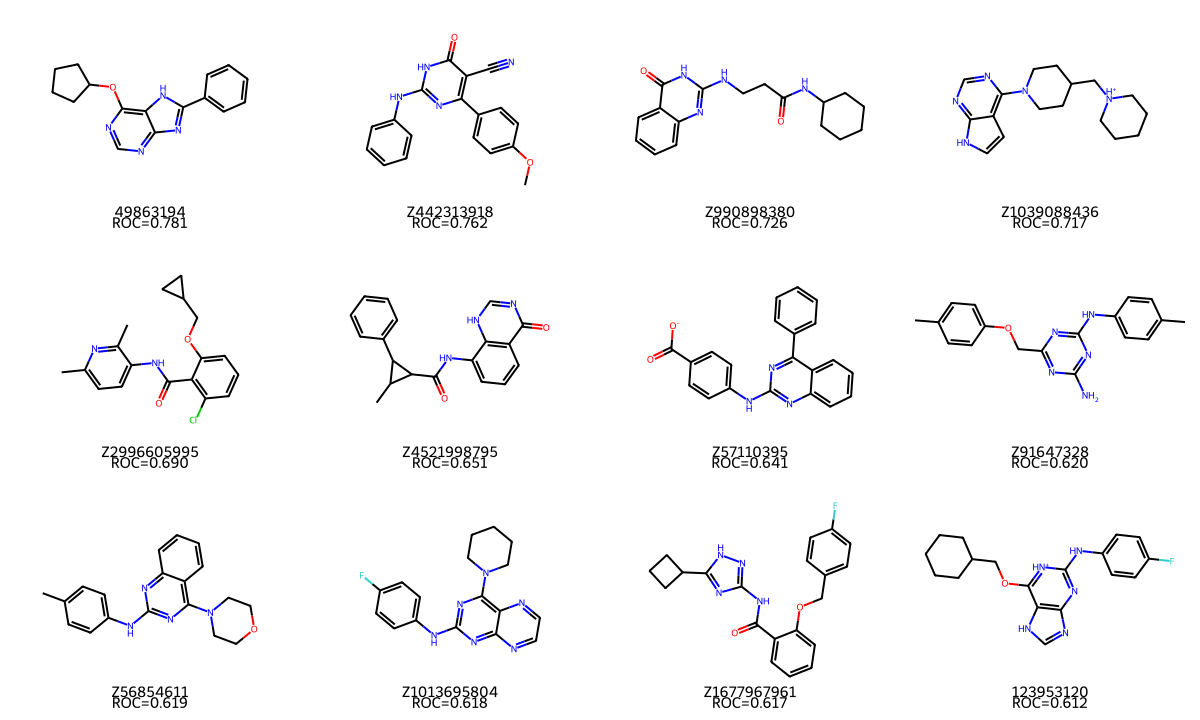

In [15]:
# === Parameters ===
TOP_N = 12         # number of ligands to display
N_COLS = 4         # columns per row
CELL_SIZE = (300, 240)

# === Get top ligands ===
top_df = df.head(TOP_N).copy()

# === Convert SMILES to Mol objects ===
mols = [Chem.MolFromSmiles(smi) for smi in top_df["SMILES"]]

# === Create legend labels (CID + ROC score) ===
legends = [
    f"{cid}\nROC={score:.3f}"
    for cid, score in zip(top_df["CID"], top_df["ROC_score"])
]

# === Generate grid ===
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=N_COLS,
    subImgSize=CELL_SIZE,
    legends=legends,
    useSVG=False
)

# === Display in notebook ===
display(img)

## Step 4: Extraction of Top-Ranked Ligand Poses

Thextracts and organizes **top-ranked ligands** (based on composite ROC scores) from the docking results SDF file.  
It ensures that only the **best-performing candidates**—based on combined docking and ADME criteria—are carried forward for structural inspection or further analysis.

#### **Workflow**
1. **Configuration**
   - Define input paths:
     - `HITS_SDF` → SDF file containing all docked poses.  
     - `TOP_POSE_CSV` → Ranked CSV from the ROC-based scoring step.  
   - Set the number of top ligands to extract (`TOP_N = 20`).  
   - Create the output directory (`OUT_DIR`).

2. **Load Top-Ranked Ligands**
   - Read the ranked CSV file and select the top **N ligands** by descending `ROC_score`.

3. **Read Docking Poses**
   - Load all molecules from `hits.sdf` using RDKit’s `SDMolSupplier`.  
   - Group poses by compound ID (`CID`), extracted from the molecule name field.

4. **Export Top Ligands**
   - For each top-ranked `CID`, collect all its poses and write them to individual SDF files.  
   - Each file is saved in `step5-ranked-outputs/` as `<CID>_ranked.sdf`.

#### **Output**
- **Folder:** `step5-ranked-outputs/`  
- **Contents:** One SDF file per top-ranked compound, containing all its docked poses.  
- Provides a curated subset of ligands ready for clustering, visualization, or subsequent rescoring.

This step finalizes the **hit selection phase**, bridging the scoring-based triage and the structural clustering analyses that follow.


In [25]:
import os
import pandas as pd
from rdkit import Chem

# === CONFIGURATION ===
HITS_SDF = "output_step4-v6/hits.sdf"   # path to your hits.sdf file
TOP_POSE_CSV = "ligand_ranked_ROC.csv"     # ranked CSV from ROC step
CSV_CID_COL = "CID"
CSV_SCORE_COL = "ROC_score"
TOP_N = 50
OUT_DIR = "step5-ranked-outputs"

os.makedirs(OUT_DIR, exist_ok=True)

# === Step 1 — Load top-ranked ligand IDs ===
rank_df = pd.read_csv(TOP_POSE_CSV)
rank_df = rank_df.sort_values(CSV_SCORE_COL, ascending=False)
top_cids = rank_df[CSV_CID_COL].head(TOP_N).astype(str).tolist()
print(f"Selected top {len(top_cids)} CIDs:", top_cids[:5], "...")

# === Step 2 — Load hits.sdf once ===
suppl = Chem.SDMolSupplier(HITS_SDF, removeHs=False)
mols = [m for m in suppl if m is not None]
print(f"Loaded {len(mols)} molecules from hits.sdf")

# === Step 3 — Group molecules by CID (from _Name or ID field) ===
mol_dict = {}
for mol in mols:
    name = mol.GetProp("_Name") if mol.HasProp("_Name") else ""
    # strip any suffixes like "_pose1" or "_dock"
    cid = name.split("_")[0]
    if cid not in mol_dict:
        mol_dict[cid] = []
    mol_dict[cid].append(mol)

# === Step 4 — Write top-ranked ligands ===
written = 0
for cid in top_cids:
    if cid not in mol_dict:
        print(f"{cid} not found in hits.sdf, skipping")
        continue

    out_path = os.path.join(OUT_DIR, f"{cid}_ranked.sdf")
    writer = Chem.SDWriter(out_path)
    for m in mol_dict[cid]:
        writer.write(m)
    writer.close()

    written += 1
    print(f"Wrote {len(mol_dict[cid])} pose(s) for {cid} → {out_path}")

print(f"Done — {written} SDF files written to '{OUT_DIR}'")


Selected top 50 CIDs: ['49863194', 'Z442313918', 'Z990898380', 'Z1039088436', 'Z2996605995'] ...
Loaded 514 molecules from hits.sdf
Wrote 10 pose(s) for 49863194 → step5-ranked-outputs/49863194_ranked.sdf
Wrote 10 pose(s) for Z442313918 → step5-ranked-outputs/Z442313918_ranked.sdf
Wrote 8 pose(s) for Z990898380 → step5-ranked-outputs/Z990898380_ranked.sdf
Wrote 8 pose(s) for Z1039088436 → step5-ranked-outputs/Z1039088436_ranked.sdf
Wrote 8 pose(s) for Z2996605995 → step5-ranked-outputs/Z2996605995_ranked.sdf
Wrote 6 pose(s) for Z4521998795 → step5-ranked-outputs/Z4521998795_ranked.sdf
Wrote 7 pose(s) for Z57110395 → step5-ranked-outputs/Z57110395_ranked.sdf
Wrote 6 pose(s) for Z91647328 → step5-ranked-outputs/Z91647328_ranked.sdf
Wrote 8 pose(s) for Z56854611 → step5-ranked-outputs/Z56854611_ranked.sdf
Wrote 7 pose(s) for Z1013695804 → step5-ranked-outputs/Z1013695804_ranked.sdf
Wrote 5 pose(s) for Z1677967961 → step5-ranked-outputs/Z1677967961_ranked.sdf
Wrote 5 pose(s) for 123953120 

## Step 5:  Clustering and Selection of Structurally Diverse Hits

This section clusters the top 50 ranked ligands from the ROC-based ranking to identify chemically related scaffolds and representative compounds for further evaluation. The clustering is performed using ECFP4 (Morgan radius 2) fingerprints and Tanimoto similarity, followed by Butina clustering with a similarity cutoff of 0.6.

#### Methodology
1. **Input Preparation**  
   The top 50 ligands were selected from the ranked list (`ligand_ranked_ROC.csv`).

2. **Fingerprint Generation**  
   Each molecule was represented using ECFP4 fingerprints (2048-bit vectors) generated with RDKit’s `MorganGenerator`.

3. **Similarity Computation and Clustering**  
   Pairwise Tanimoto similarities were calculated and converted to distances (1 – similarity).  
   Molecules were then grouped using Butina clustering with a cutoff of 0.6.

4. **Cluster Analysis**  
   For each cluster, the number of members, mean intra-cluster Tanimoto similarity, and the corresponding CIDs and ROC ranks were summarized.  
   Visual inspection revealed that:
   - The top PubChem crystal-analogous hits clustered together with the co-crystal ligand (**COLIG_2A6**).  
   - However, using the current selection algorithm, **COLIG_2A6** will **not be chosen for purchase** since it ranks lower than other analogs within the same cluster.  
   - Other clusters consisted of chemically similar analogs exhibiting diverse scaffolds, offering promising options for lead identification and optimization.

#### Interpretation
- Clusters with high mean Tanimoto similarity represent analog series or scaffold families.  
- Singleton clusters correspond to unique chemotypes that contribute to scaffold diversity.  
- Overall, the clustering demonstrates that the ROC-based ranking effectively balances ligand quality and scaffold diversity, while deprioritizing redundant or lower-performing analogs.

#### Next Steps
The next step is to select representative compounds from each cluster for further evaluation:
- For **multi-member clusters**, select the **top-ranked compound** (based on ROC rank) as the cluster representative.  
- For **singleton clusters**, retain the single compound as-is.  

This process yields a focused yet chemically diverse subset of ligands suitable for downstream docking refinement, ADMET profiling, or purchase prioritization.


Generated 31 clusters at cutoff = 0.6


,Cluster_ID,Num_Members,Mean_Tanimoto,CIDs,Top_Ranks
0,1,8,0.472,"COLIG_2A6, 123953120, 76328458, 5329560, 53295...","17, 11, 16, 20, 22, 23, 36, 39"
1,2,4,0.593,"Z3590543759, Z2996605995, Z2994634090, Z300695...","47, 4, 13, 27"
2,3,3,0.700,"Z94803042, Z57110395, Z357964720","46, 6, 43"
3,4,3,0.463,"Z1198960055, Z3000762692, Z1463055422","40, 24, 32"
4,5,3,0.554,"Z89684168, Z91647328, Z91661383","31, 7, 26"
5,6,1,0.000,49863194,0
6,7,2,0.485,"Z1192499493, Z3071600379","45, 34"
7,8,2,0.554,"Z1657740785, Z1657744734","38, 29"
8,9,2,0.418,"Z1127203562, Z990898380","25, 2"
9,10,1,0.000,Z352550402,49



Cluster 1 — 8 molecules | Mean Tanimoto: 0.472


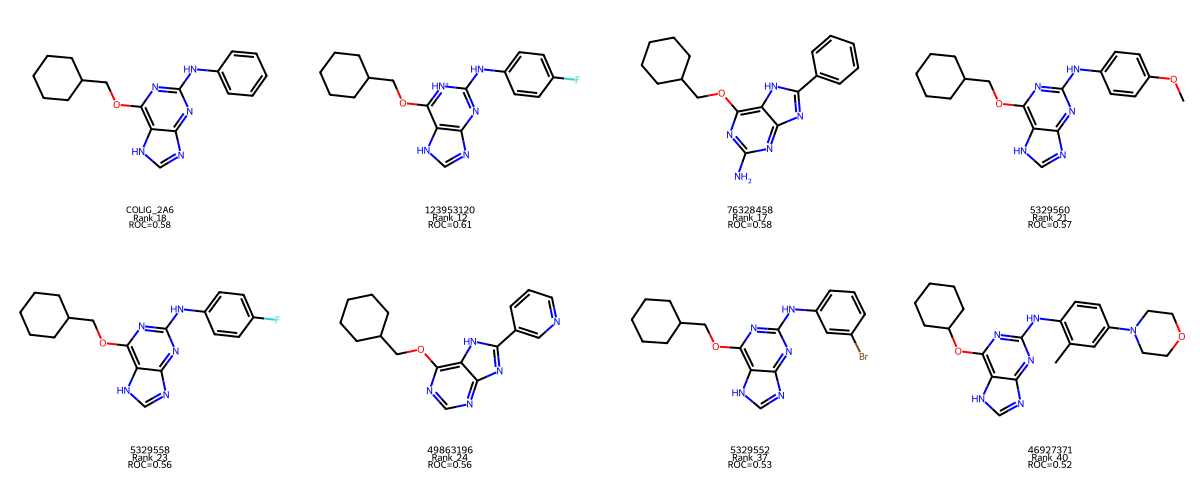


Cluster 2 — 4 molecules | Mean Tanimoto: 0.593


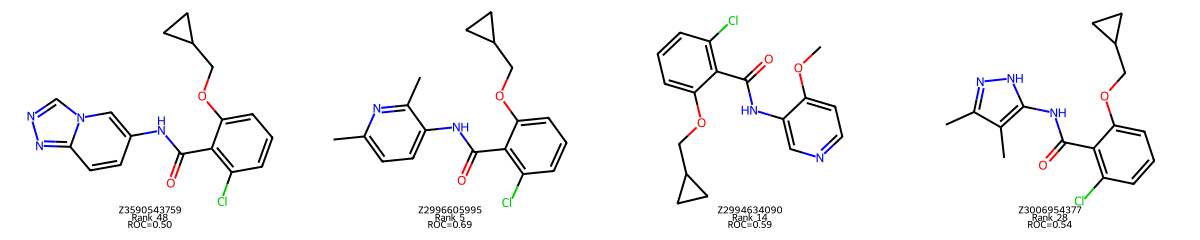


Cluster 3 — 3 molecules | Mean Tanimoto: 0.7


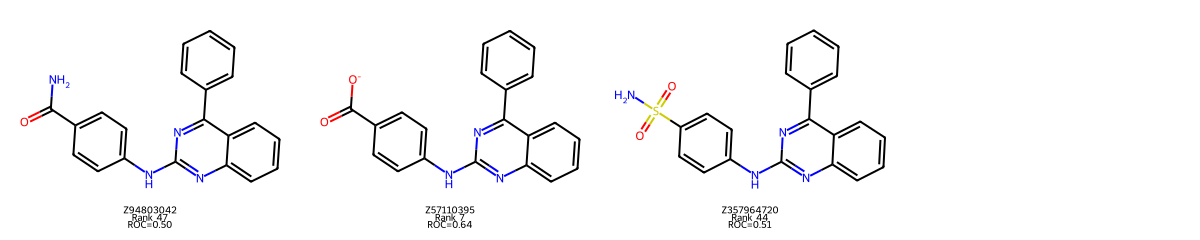


Cluster 4 — 3 molecules | Mean Tanimoto: 0.463


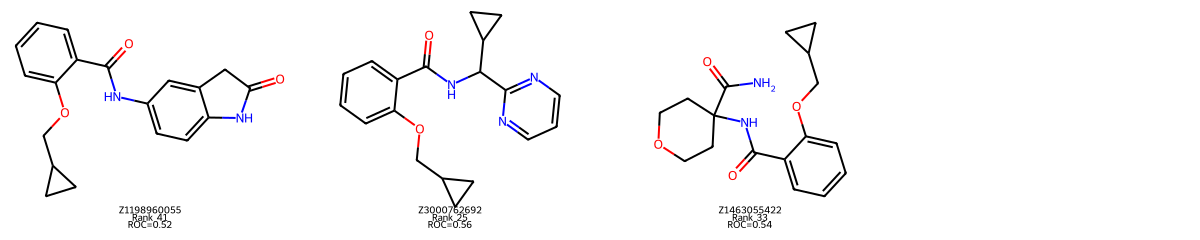


Cluster 5 — 3 molecules | Mean Tanimoto: 0.554


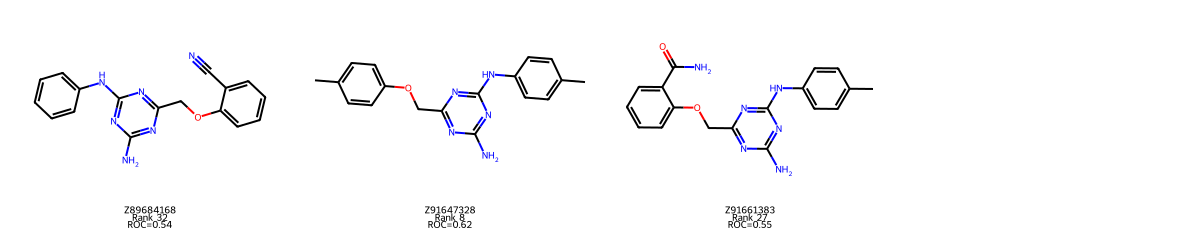


Cluster 6 — 1 molecules | Mean Tanimoto: 0.0


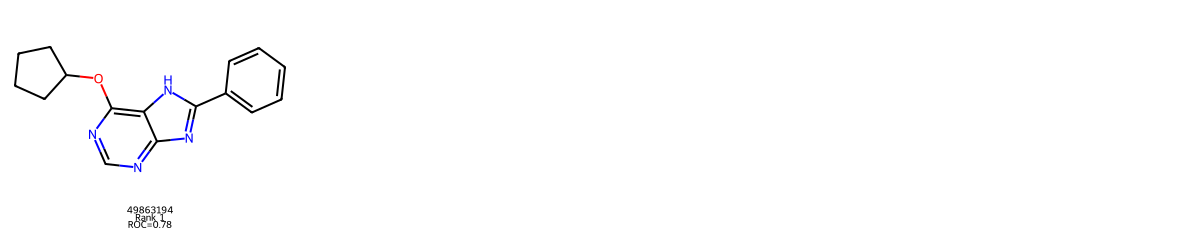


Cluster 7 — 2 molecules | Mean Tanimoto: 0.485


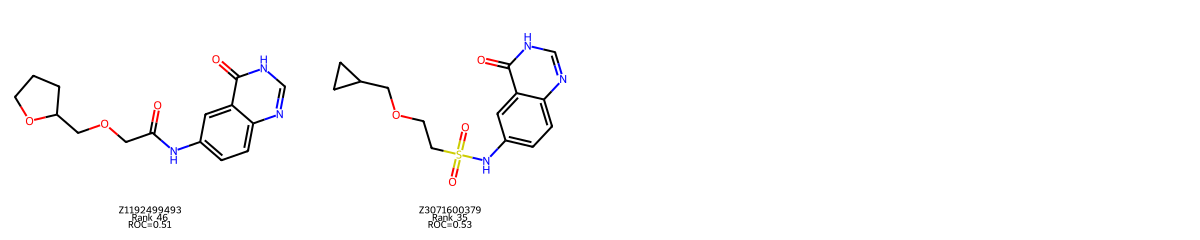


Cluster 8 — 2 molecules | Mean Tanimoto: 0.554


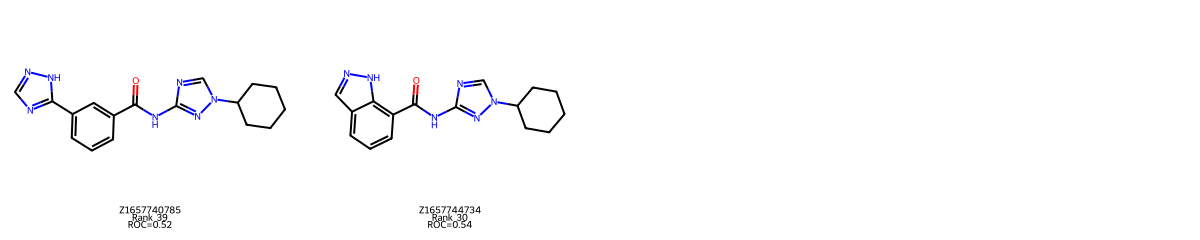


Cluster 9 — 2 molecules | Mean Tanimoto: 0.418


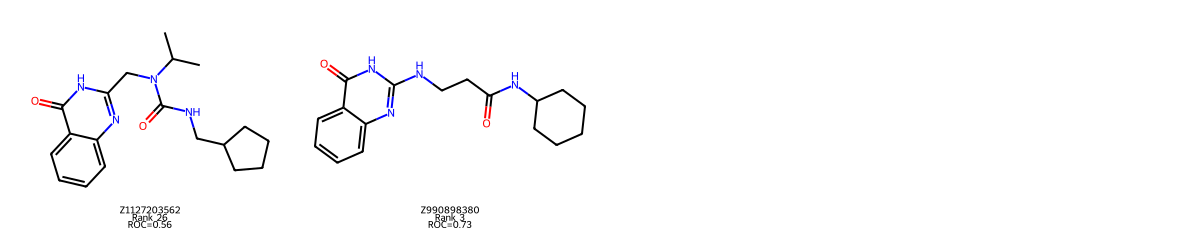


Cluster 10 — 1 molecules | Mean Tanimoto: 0.0


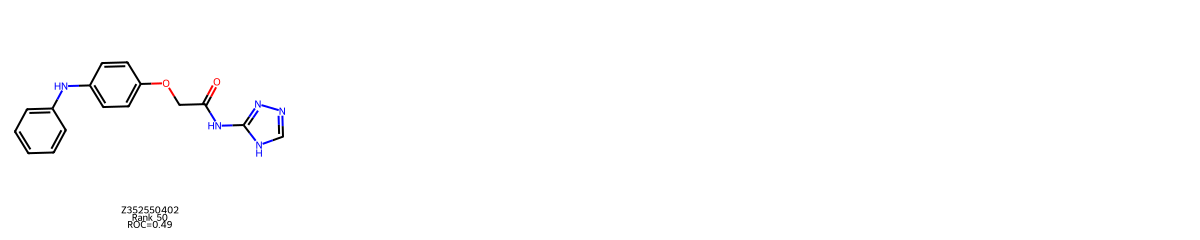


Cluster 11 — 1 molecules | Mean Tanimoto: 0.0


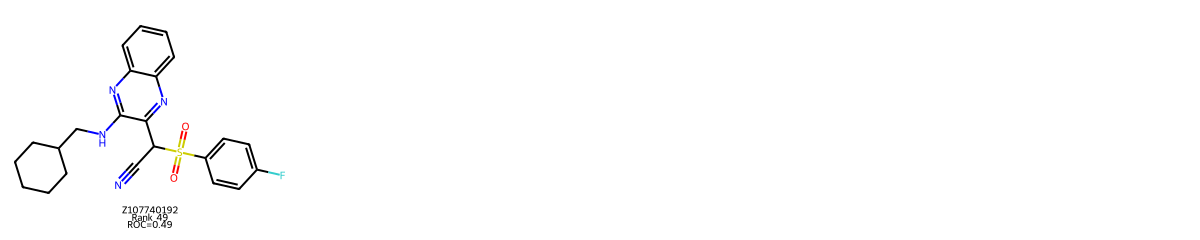


Cluster 12 — 1 molecules | Mean Tanimoto: 0.0


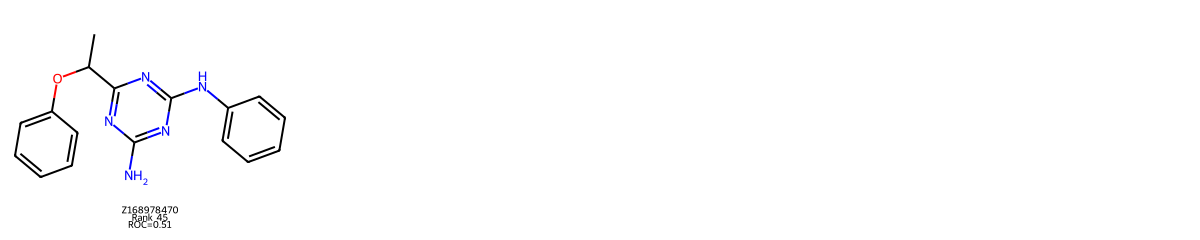


Cluster 13 — 1 molecules | Mean Tanimoto: 0.0


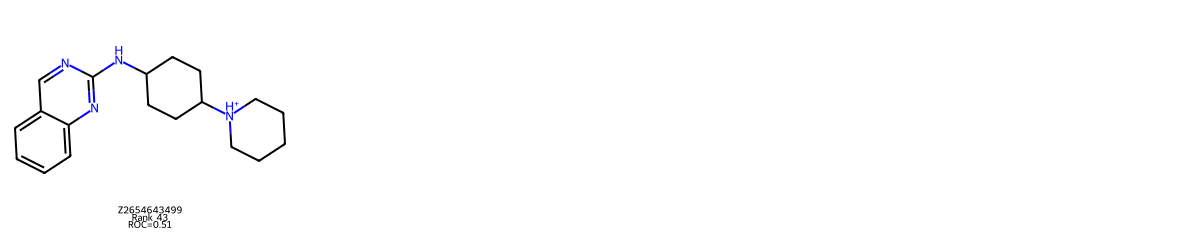


Cluster 14 — 1 molecules | Mean Tanimoto: 0.0


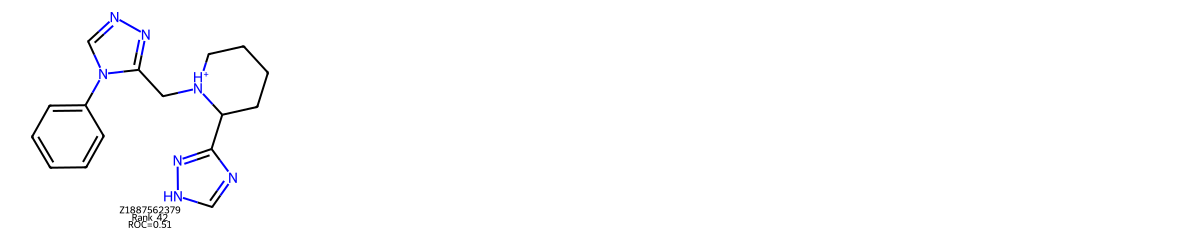


Cluster 15 — 1 molecules | Mean Tanimoto: 0.0


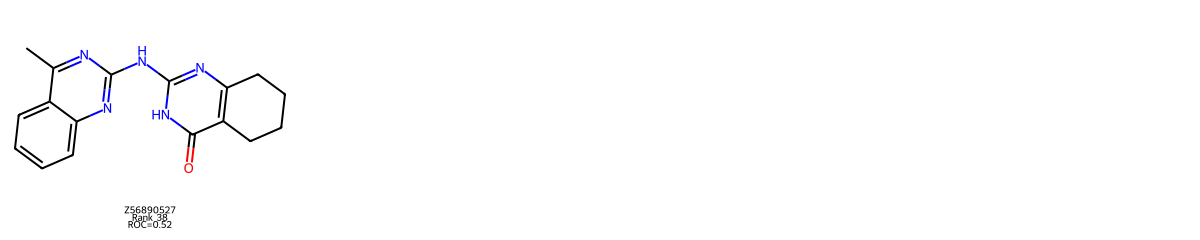


Cluster 16 — 1 molecules | Mean Tanimoto: 0.0


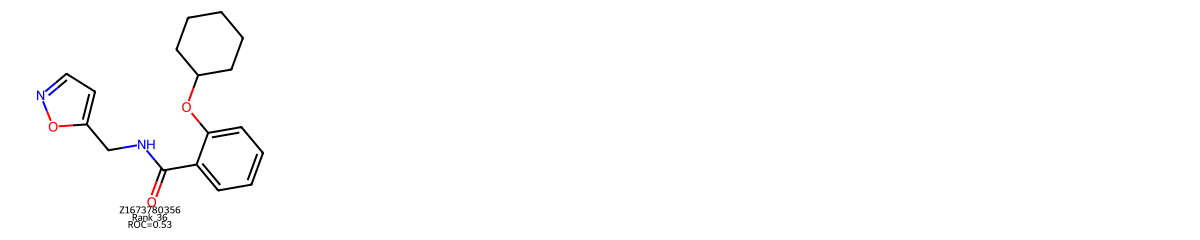


Cluster 17 — 1 molecules | Mean Tanimoto: 0.0


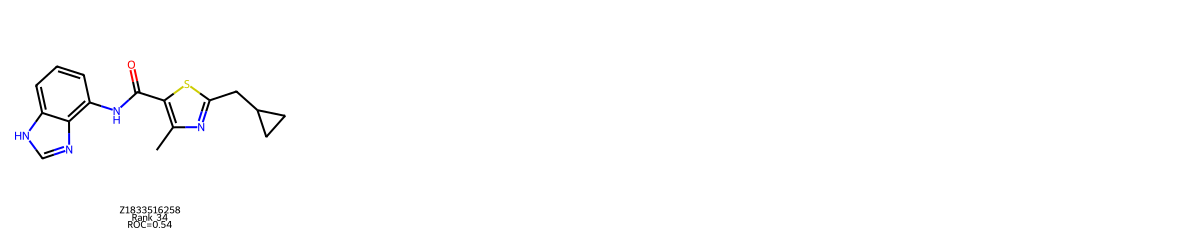


Cluster 18 — 1 molecules | Mean Tanimoto: 0.0


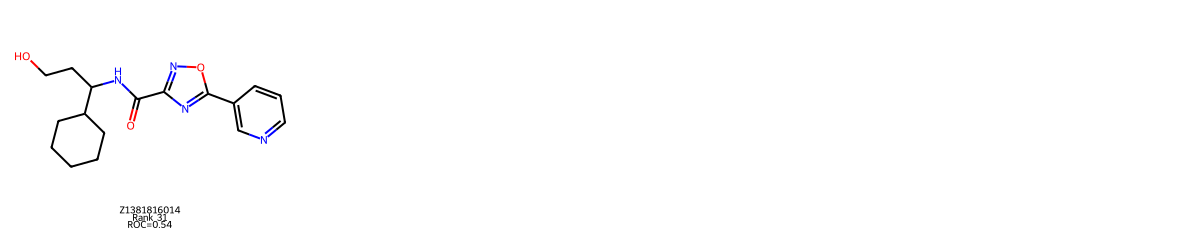


Cluster 19 — 1 molecules | Mean Tanimoto: 0.0


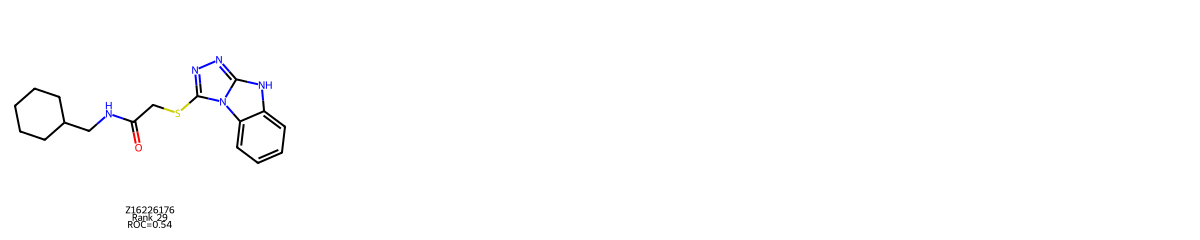


Cluster 20 — 1 molecules | Mean Tanimoto: 0.0


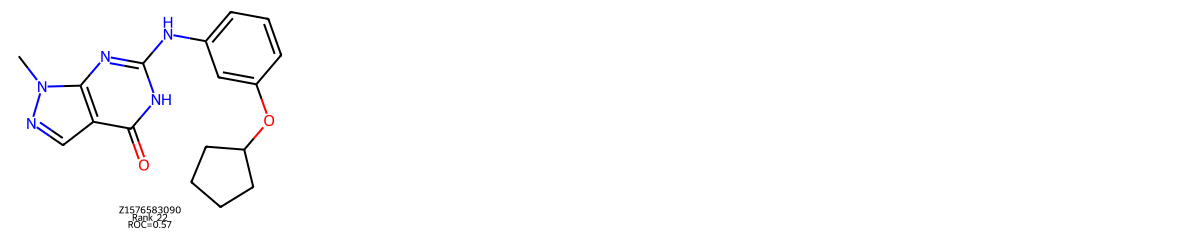


Cluster 21 — 1 molecules | Mean Tanimoto: 0.0


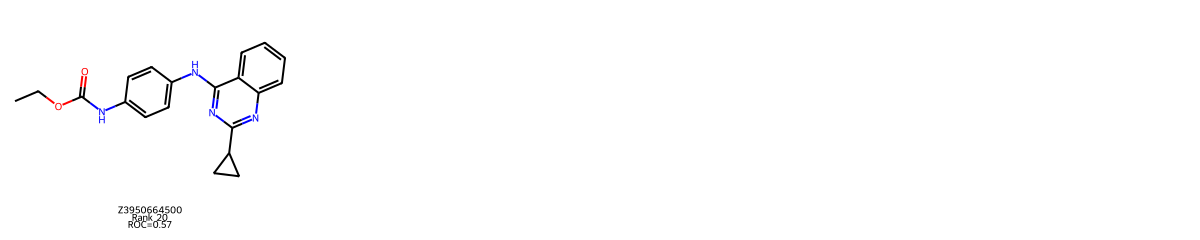


Cluster 22 — 1 molecules | Mean Tanimoto: 0.0


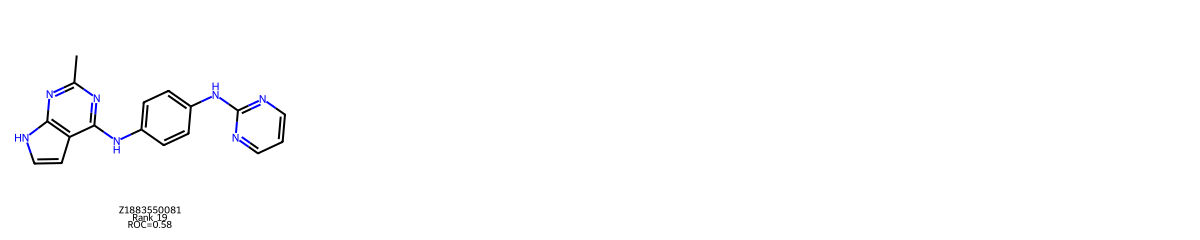


Cluster 23 — 1 molecules | Mean Tanimoto: 0.0


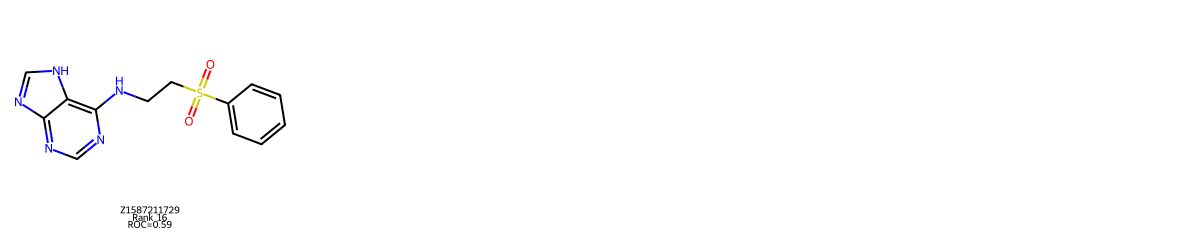


Cluster 24 — 1 molecules | Mean Tanimoto: 0.0


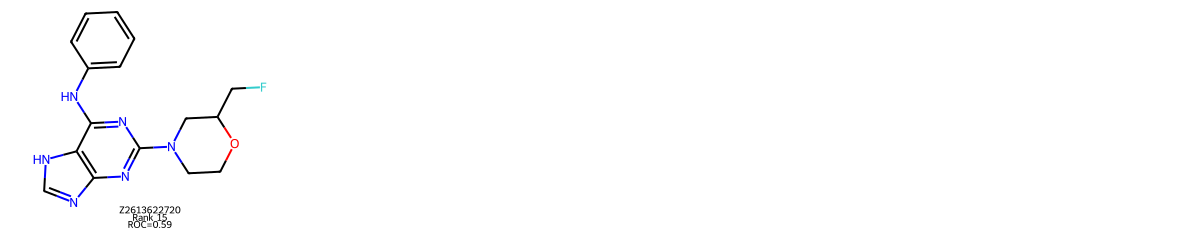


Cluster 25 — 1 molecules | Mean Tanimoto: 0.0


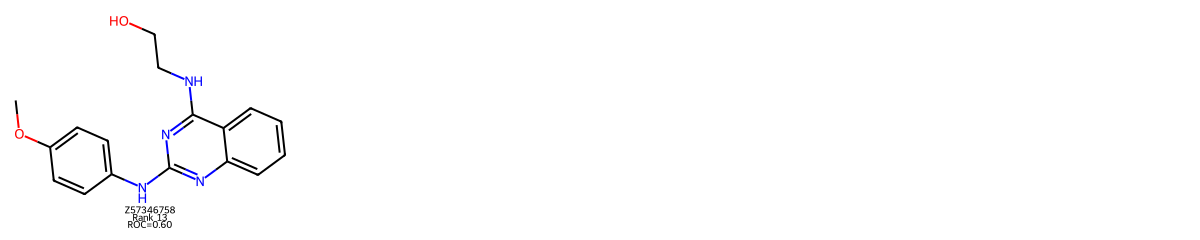


Cluster 26 — 1 molecules | Mean Tanimoto: 0.0


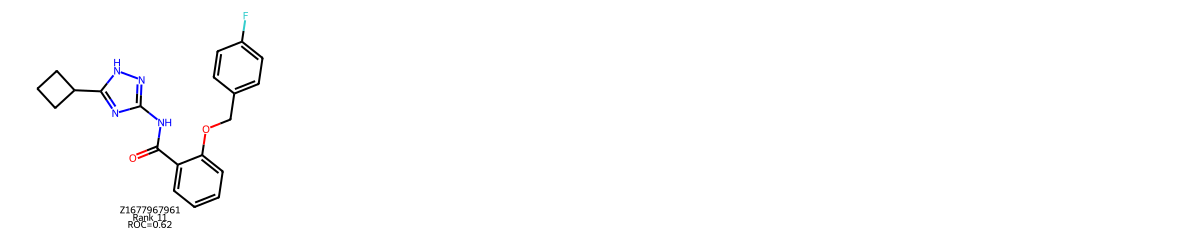


Cluster 27 — 1 molecules | Mean Tanimoto: 0.0


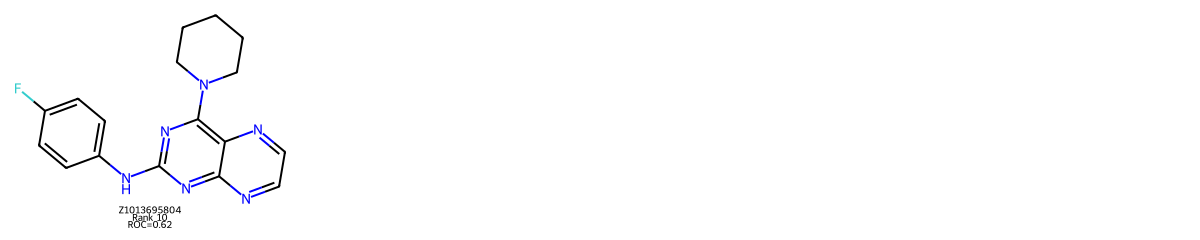


Cluster 28 — 1 molecules | Mean Tanimoto: 0.0


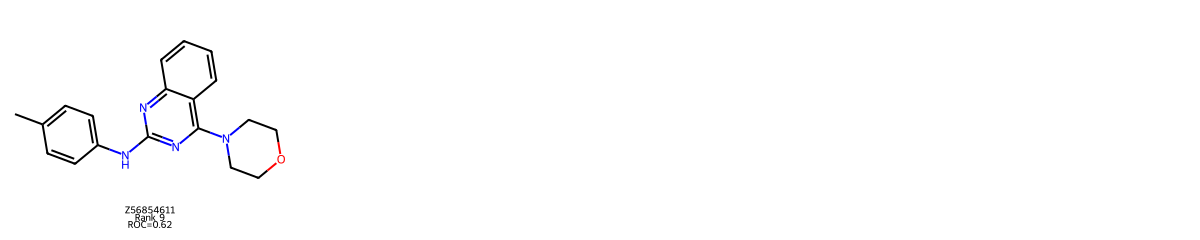


Cluster 29 — 1 molecules | Mean Tanimoto: 0.0


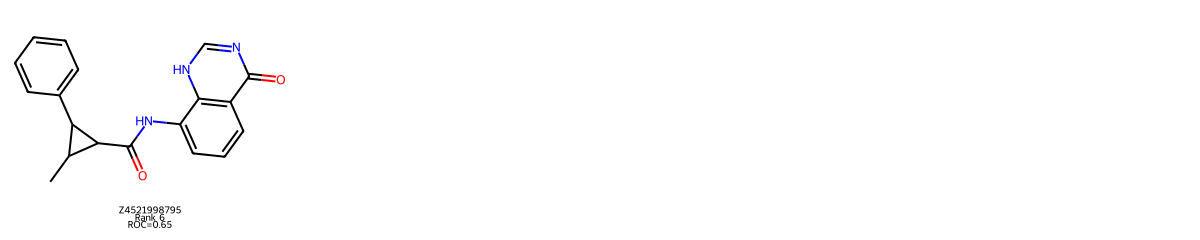


Cluster 30 — 1 molecules | Mean Tanimoto: 0.0


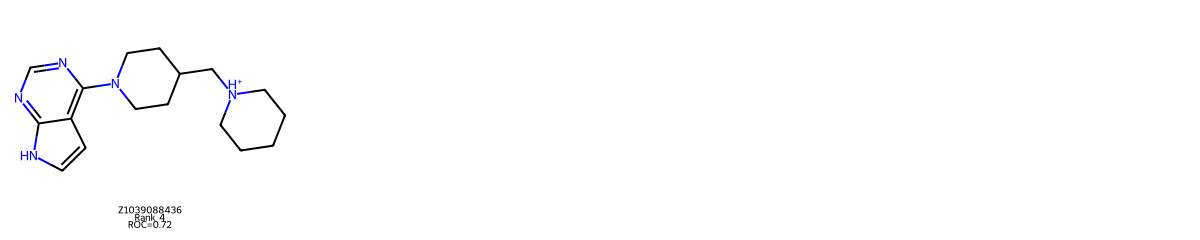


Cluster 31 — 1 molecules | Mean Tanimoto: 0.0


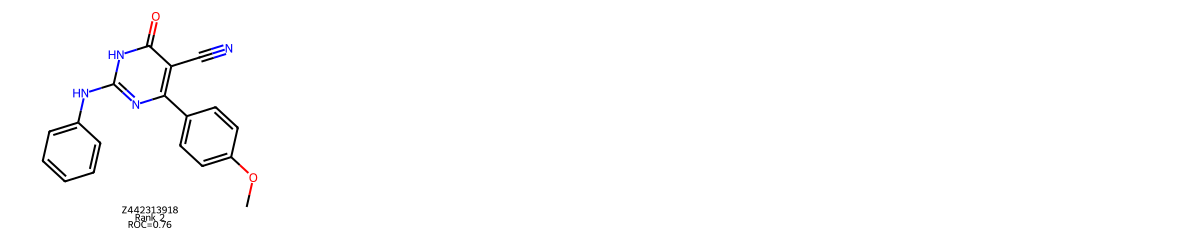

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
import pandas as pd
import numpy as np

# === CONFIGURATION ===
TOP_POSE_CSV = "ligand_ranked_ROC.csv"
TOP_N = 50
CLUSTER_CUTOFF = 0.6  # Tanimoto similarity threshold

# === Step 1 — Load and filter ===
df = pd.read_csv(TOP_POSE_CSV).sort_values("ROC_score", ascending=False).head(TOP_N)
mols = [Chem.MolFromSmiles(s) for s in df["SMILES"] if Chem.MolFromSmiles(s)]
df = df.iloc[:len(mols)].copy()

# === Step 2 — Generate Morgan fingerprints ===
fpgen = GetMorganGenerator(radius=2, fpSize=2048)
fps = [fpgen.GetFingerprint(m) for m in mols]

# === Step 3 — Compute Tanimoto distance matrix ===
dists = []
for i in range(1, len(fps)):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
    dists.extend([1 - x for x in sims])

# === Step 4 — Butina clustering ===
clusters = Butina.ClusterData(dists, len(fps), CLUSTER_CUTOFF, isDistData=True)
print(f"Generated {len(clusters)} clusters at cutoff = {CLUSTER_CUTOFF}")

# === Step 5 — Annotate cluster IDs ===
cluster_ids = {}
for cid, cluster in enumerate(clusters):
    for idx in cluster:
        cluster_ids[idx] = cid + 1
df["Cluster_ID"] = [cluster_ids.get(i, None) for i in range(len(mols))]

# === Step 6 — Cluster summaries ===
cluster_summary = []
for i, cluster in enumerate(clusters, start=1):
    members = df.iloc[list(cluster)]
    member_cids = members["CID"].tolist()
    member_scores = members["ROC_score"].tolist()
    mean_sim = 0
    if len(cluster) > 1:
        sims = []
        for j in range(len(cluster)):
            for k in range(j + 1, len(cluster)):
                sims.append(DataStructs.TanimotoSimilarity(fps[cluster[j]], fps[cluster[k]]))
        mean_sim = np.mean(sims)
    cluster_summary.append({
        "Cluster_ID": i,
        "Num_Members": len(cluster),
        "Mean_Tanimoto": round(mean_sim, 3),
        "CIDs": ", ".join(map(str, member_cids)),
        "Top_Ranks": ", ".join(map(str, members.index.tolist()))
    })

summary_df = pd.DataFrame(cluster_summary)
display(summary_df)

# === Step 7 — Visualize clusters inline ===
for i, cluster in enumerate(clusters, start=1):
    members = df.iloc[list(cluster)]
    mols_cluster = [mols[idx] for idx in cluster]
    legends = [
        f"{cid}\nRank {idx+1}\nROC={score:.2f}"
        for cid, idx, score in zip(members["CID"], members.index, members["ROC_score"])
    ]
    img = Draw.MolsToGridImage(
        mols_cluster,
        molsPerRow=4,
        subImgSize=(300, 240),
        legends=legends,
        useSVG=False
    )
    print(f"\nCluster {i} — {len(cluster)} molecules | Mean Tanimoto: {summary_df.loc[i-1, 'Mean_Tanimoto']}")
    display(img)
